# Introducción
En este proyecto intento generar una interfaz o aplicación en la cual cualquier persona adulta pueda conocer su probabilidad de sufrir enfermedad cardiovascular (EC): angina de pecho (mal llamado preinfarto) o infarto agudo de miocardio. 
El objetivo es lograr esta predicción, o aproximación, mediante la respuesta rápida a preguntas simples y que puedan responderse en una encuesta sencilla y ágil.
Es amplia la bibliografía y el conocimiento de los antecedentes de esta patología. No podemos dejar de nombrar al estudio de Framingham al referirnos a la enfermedad cardiovascular.
Es un estudio prospectivo de grandes dimensiones realizado en la ciudad de Framingham, EEUU, con los habitantes de ese lugar. Este estudio se inició en el año 1948 y continua en vigencia aún. Consiste en la evaluación de las condiciones y estilos de vida de los habitantes de esta ciudad y determinar conclusiones sobre enfermedades cardiovasculares. Ya lleva incluidas 3 generaciones de familias en el estudio. Estas conclusiones aportaron muchísima evidencia a lo que se conoce como factores de predisposición para la enfermedad cardiovascular.
De este estudio se desprende el Framingham Risk Score. Este score permite establecer con alta eficacia el riesgo de sufrir enfermedad cardiovascular en un plazo de 10 años. Incorpora datos específicos como valores de laboratorio de colesterol (HDL, LDL, Triglicéridos), glucemia, presión diástolica y sistólica, fumadores, género y edad.
Este Score determina el riesgo elevado, medio o alto de sufrir enfermedad cardiovascular dentro de los 10 años.



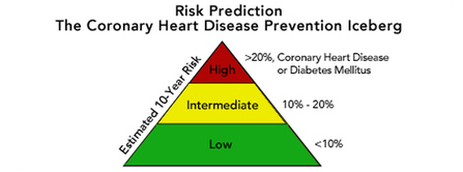

Si bien este Score cuenta con alto rigor científico, no puede realizarse de manera rápida y ágil, ya que precisa de determinaciones de laboratorio y evaluación médica presente del paciente.

En este proyecto, utilizando una gran base de datos de pacientes adultos, realizamos el análisis de estos 400.000 pacientes y proponemos un modelo predictivo basado en las variables mas representativas, para lograr, de manera ágil y sencilla, predecir la probabilidad de desarrollar enfermedad cardiovascular.



# Base de datos

Tomamos como punto de partida esta base de datos recogidos por el Central Control Disease (CDC) en el año 2020, provenientes del Behavioral Risk Factor Surveillance System (BRFSS), con encuestas anuales via telefónica en diferentes ciudades de EEUU. Con 18 variables y aproximadamente 400K pacientes.
Estimo que esta gran cantidad de datos recopilados pudo hacerse efectiva gracias al medio de recolección (via telefónica) y a la característica de las preguntas, por ejemplo: "Tiene dificultad para caminar?", "Se considera con buena salud?", "Fuma?". Que devuelven respuestas sencillas y rápidas.
Estas variables son las que nos permiten desarrollar el modelo predictivo a partir de datos "no tan específicos".
Si bien son 18 variables, intentamos identificar las mas representativas relacionadas con la EC. Por ejemplo, "Cancer de piel" tiene poca relación según el marco teórico científico. 

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [2]:
archivo="https://docs.google.com/spreadsheets/d/e/2PACX-1vQXG_txJ9jlDKSq8l4K6dBb9SsGM7VE0KhBZJ3u9v0lN-zJfxiLw92sVoAQo6hjTOBYGrrwJcUIMBu5/pub?gid=1692890499&single=true&output=csv"
dfcardio=pd.read_csv(archivo, sep=",")


In [3]:
dfcardio.head()
#print(len(dfcardio))

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [4]:
dfcardio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

Por suerte, la base de datos en crudo, parece bastante limpia. No cuenta con datos vacios, como se ve en el gráfico siguiente.

Si tenemos que considerar que varias variables tienen categorías dentro y además muchos datos string. Que debemos acondicionar para utlizarlos en el algoritmo matemático

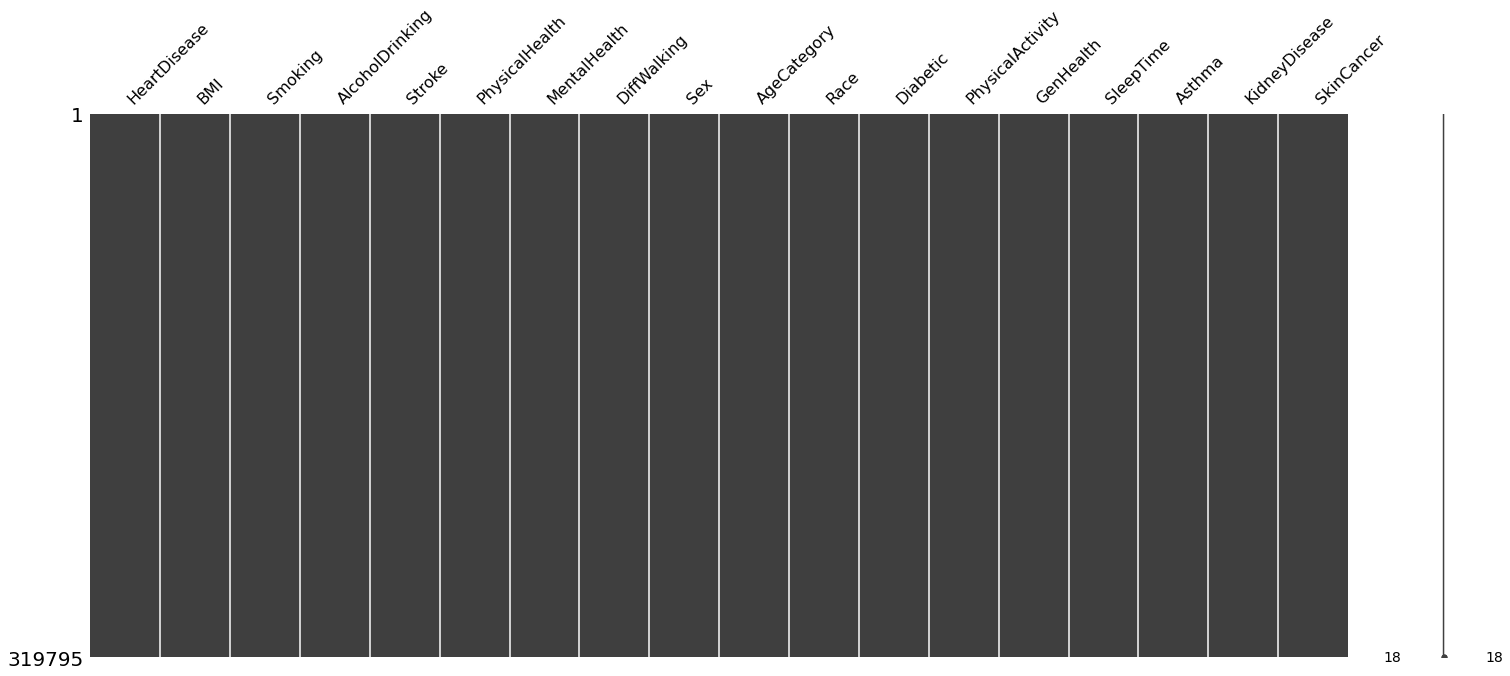

In [5]:
import missingno as msno
%matplotlib inline
msno.matrix(dfcardio)



# Evaluación de datos para determinar si la muestra es representativa para tal fin
Aquí realizamos un somero análisis de los datos, para corroborar que haya cierta semejanza con la evidencia científica conocida. Tomo como referencia la distribución de las personas según su BMI. El BMI o Body Mass Index o Indice de Masa Corporal corresponde al peso divido la talla al cuadrado expresada en metros

**BMI= peso / talla²**

Se clasifica en 4 grupos

Por debajo de 18.5:	Bajo peso

Entre 18.5 – 24.9:	Normal

Entre 25.0 – 29.9:	Sobrepeso

Por arriba de 30.0: Obesidad


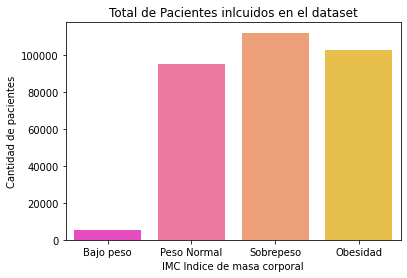

In [6]:

hdsi=dfcardio["HeartDisease"]
#print(hdsi)
cardio=dfcardio[dfcardio["HeartDisease"]=="Yes"]
nocardio=dfcardio[dfcardio["HeartDisease"]=="No"]

IMC_bajo=dfcardio[dfcardio["BMI"]<=18.5]
IMC_normal=dfcardio[(dfcardio.BMI > 18.5) & (dfcardio.BMI <= 24.9)]
IMC_sobrep=dfcardio[(dfcardio.BMI >25) & (dfcardio.BMI <=29.9)]
IMC_obesidad=dfcardio[(dfcardio.BMI >30)]


imcx=["Bajo peso", "Peso Normal","Sobrepeso","Obesidad"]
imcy=[len(IMC_bajo),len(IMC_normal),len(IMC_sobrep),len(IMC_obesidad)]

fig1, ax1 = plt.subplots()

ax1=sns.barplot(data=dfcardio, x=imcx, y=imcy, ci=95, palette="spring")

plt.title('Total de Pacientes inlcuidos en el dataset')
plt.xlabel('IMC Indice de masa corporal')
plt.ylabel('Cantidad de pacientes')


plt.show()

cardio_n=len(cardio)
nocardio_n=len(nocardio)




Según sus BMI los pacientes encuestados se ubican en estas categorias.
Se evidencia la escasa cantidad de personas de bajo peso. Pueda explicarse a que los pacientes son "adultos" de EEUU, donde los hábitos dietéticos y de consumo son particulares en comparación a otras regiones.

**Esta distribución me acerca a pensar que los datos realmente reflejan la población encuestada.**

Situación distinta sería que de 400k encuestados en EEUU la mayoría pertenezca al grupo de bajo peso, eso si despertaria sospechas sobre la veracidad de la toma de muestra.

**Realizo otro análisis para observar la relación de la EC con el BMI.**

En los siguientes gráficos de torta, se observa la incidencia de EC según la clasificación de BMI.

En la literatura los pacientes adultos pertenecientes al grupo de clasificación "Obesidad" según sus BMI son mas propensos a padecer enfermedad cardiovascular en relación al grupo: "Bajo peso", "Normal" y "Sobrepeso".

Además observamos que los pacientes clasificados como "Bajo peso" presentan un riesgo relativamente aumentado en relación a los clasificados como "Normal".
Si bien, llamó mi atención en un principio, al revisar la bibliografía esto es realmente así. Ser extremadamente delgado presenta mas riesgos que pertencer al peso/talla "normal".

**Esta observación, que surgió de ver los gráficos, me muestra que los datos no solo representan un numero importante de pacientes, si no que asemejan mucho a lo que la bibliografía médica ya conoce.**

**Por lo que me parece que utilizar esta muestra para desarrollar un modelo predictivo es prometedor!.** 


Clasificación de BMI o IMC 
menos a 18,5 -> Bajo
18,5 a 24,9 -> Normal
25 a 29,9 -> Sobrepeso
> 30 -> se considera obesidad




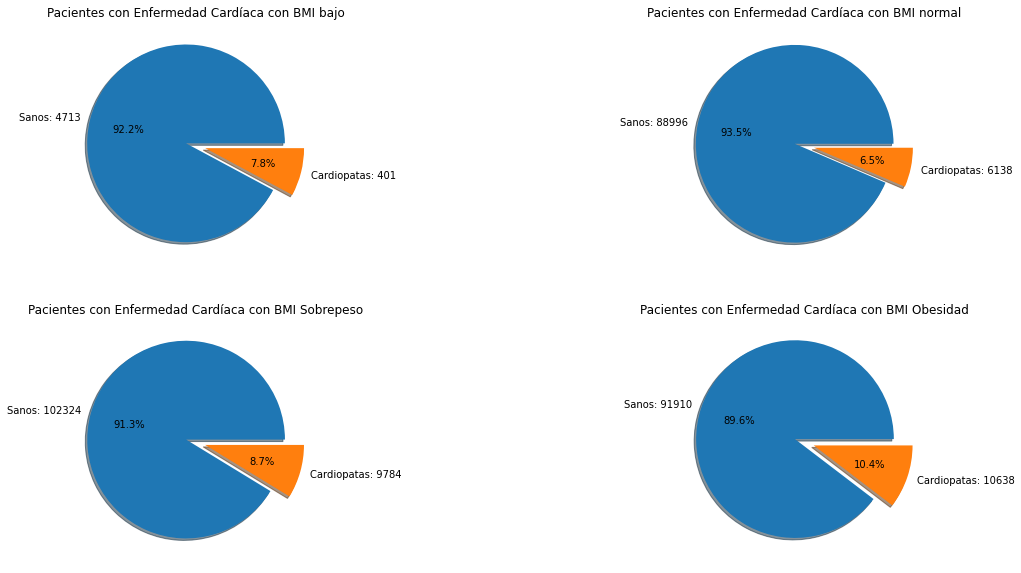

In [7]:
#fig2, axa = plt.subplots(2,2)

print("Clasificación de BMI o IMC ")
print("menos a 18,5 -> Bajo")
print("18,5 a 24,9 -> Normal")
print("25 a 29,9 -> Sobrepeso")
print("> 30 -> se considera obesidad")
print()
print()

enfbajo=dfcardio[(dfcardio["BMI"]<=18.5) & (dfcardio["HeartDisease"]=="Yes")]
enfmoderado=dfcardio[(dfcardio.BMI >18.5) & (dfcardio.BMI < 24.9) & (dfcardio.HeartDisease =="Yes")]
enfermosobrepeso=dfcardio[(dfcardio.BMI >25) & (dfcardio.BMI <=29.9) & (dfcardio.HeartDisease =="Yes")]
enfermosobesos=dfcardio[(dfcardio.BMI >30) & (dfcardio.HeartDisease == "Yes")]

sect=[len(IMC_bajo)-len(enfbajo), len(enfbajo)]
sect2=[len(IMC_normal)-len(enfmoderado), len(enfmoderado)]
sect3=[len(IMC_sobrep)-len(enfermosobrepeso), len(enfermosobrepeso)]
sect4=[len(IMC_obesidad)-len(enfermosobesos), len(enfermosobesos)]


plt.figure(figsize=(20,10))


#Grafico 1
plt.subplot(221)
plt.title("Pacientes con Enfermedad Cardíaca con BMI bajo")
labela=("Sanos: "+ str(len(IMC_bajo)-len(enfbajo)), "Cardiopatas: "+str(len(enfbajo)))
plt.pie(sect,labels=labela, autopct='%1.1f%%', shadow="true", explode=(0.1 , 0.1))
plt.get_cmap("plasma")
#Grafico2
plt.subplot(222)
plt.title("Pacientes con Enfermedad Cardíaca con BMI normal")
labelb=("Sanos: "+ str(len(IMC_normal)-len(enfmoderado)), "Cardiopatas: "+str(len(enfmoderado)))
plt.pie(sect2,labels=labelb, autopct='%1.1f%%', shadow="true", explode=(0.1 , 0.1))



#grafico 3
plt.subplot(223)
plt.title("Pacientes con Enfermedad Cardíaca con BMI Sobrepeso")
labelc=("Sanos: "+ str(len(IMC_sobrep)-len(enfermosobrepeso)), "Cardiopatas: "+str(len(enfermosobrepeso)))
plt.pie(sect3,labels=labelc, autopct='%1.1f%%', shadow="true", explode=(0.1 , 0.1))


#Grafico 4
plt.subplot(224)
plt.title("Pacientes con Enfermedad Cardíaca con BMI Obesidad")
labeld=("Sanos: "+ str(len(IMC_obesidad)-len(enfermosobesos)), "Cardiopatas: "+str(len(enfermosobesos)))
plt.pie(sect4,labels=labeld, autopct='%1.1f%%', shadow="true", explode=(0.1 , 0.1))


plt.show()

print("")



# Diseño del proyecto

Realizo el análisis exploratorio de los datos. Mucho de mi conocimiento previo ya me indica cuales son las variables importantes para incorporar al modelo.

Elimino de entrada algunas variables.

Convierto las variables en numéricas bivariables.



In [8]:
ndfcardio=dfcardio.drop(["AgeCategory","GenHealth","Race","Asthma","KidneyDisease","SkinCancer","MentalHealth", "PhysicalHealth"], axis=1)
ndfcardio.head()
variablescat = ndfcardio.select_dtypes(include = ["object"]).columns  #paso las variables object a numericas
print(variablescat)

newdfcardio = pd.get_dummies(ndfcardio[variablescat], drop_first = True) #Las variables object las paso a 0 o 1 o dummies y hago copia del nuevo df
newdfcardio.head()
ndfcardio2 = ndfcardio.drop(variablescat, axis=1) # elimino las columnas originales
ndfcardio2.head()
dfcardiofinal=pd.concat([ndfcardio2, newdfcardio], axis=1).copy()  #concateno y ya quedan las nuevas


Index(['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking',
       'Sex', 'Diabetic', 'PhysicalActivity'],
      dtype='object')


Busco Outliers en "Horas de sueño"

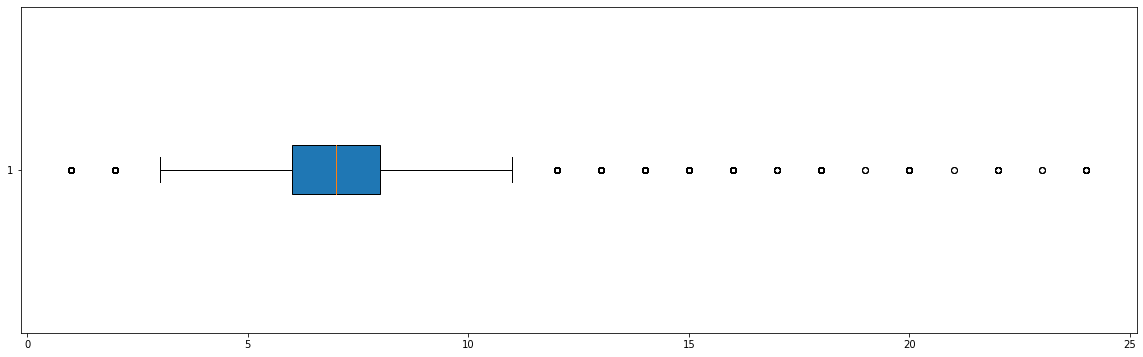

In [9]:
plt.figure(figsize=(20, 6))
graficobox=dfcardiofinal['SleepTime']
plt.boxplot(graficobox, patch_artist=True, vert=False)
plt.show()

Encuentro personas que duermen mas de 20 hs al día, los interpreto como error y los elimino.


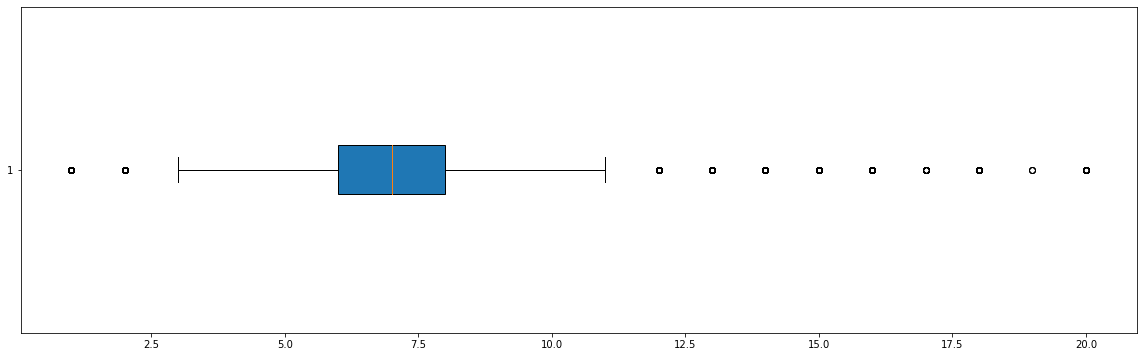

In [10]:
Df_cardio_sin_out = dfcardiofinal.drop(dfcardiofinal[dfcardiofinal['SleepTime']>20].index).copy()

plt.figure(figsize=(20, 6))
Graficobox=Df_cardio_sin_out['SleepTime']
plt.boxplot(Graficobox, patch_artist=True, vert=False)
plt.show()  ### solo máximo de 20 hs de sueño


Busco datos duplicados

In [11]:
print(Df_cardio_sin_out.duplicated())

Df_cardio_limpia=Df_cardio_sin_out.copy().drop_duplicates()
print('--------------------------')
print(len(Df_cardio_sin_out))
print(len(Df_cardio_limpia)) #Elimino los duplicados, que eran 115525 registros. Es mucha coincidencia que sean pacientes distintos pero con mismos datos
#De todas maneras los elimino para dejar mas limpio y ver el resultado al correr el algoritmo
#
# Df_cardio_limpia seria el dataset final!! Sin nulos, sin duplicados, todos en variable numerica y sin outliers




0         False
1         False
2         False
3         False
4         False
          ...  
319790     True
319791     True
319792     True
319793    False
319794    False
Length: 319751, dtype: bool
--------------------------
319751
116380


Encuentro 115525 duplicados
Elimino los duplicados. Es mucha coincidencia que sean pacientes distintos con mismas características.

Sin duplicados, ni outliers se me reduce la base de datos a 208105 registros.
Esta es la base de datos final con la que voy a entrenar.



**Feature Selection**

Identifico las variables con las que voy a trabajar.

La variable Target es HeartDisease

Utilizo esta función "SelectKBest" que elije las mejores 7 variables (k=7) que se correlacionan con la target.
Chequeo y coincide con el criterio médico.

Las que selecciona:

**bmi, smoking_yes, stroke_yes, difwalkin_yes, diabetic yes, sex_male, phisicalactivity**

me parecen correctas, las 7 son casi predictivas de enfermedad cardiovascular.



In [12]:
variables_sin_target=Df_cardio_limpia.drop(["HeartDisease_Yes"], axis=1)
dataB=variables_sin_target.values
data=Df_cardio_limpia.values

    
X=dataB[:,0:20]
Y=data[:,2]

print("---------------")

print(X)
print("----------------")
print(Y)
mejorchi = SelectKBest(score_func=chi2, k=7).fit_transform(X,Y)
print("----------------")
print(mejorchi[:20])     #me devuelve las 7 mejores de 20, pero solo los datos, tengo que comparar con el DF para saber cuales son



---------------
[[16.6   5.    1.   ...  1.    0.    1.  ]
 [20.34  7.    0.   ...  0.    0.    1.  ]
 [26.58  8.    1.   ...  1.    0.    1.  ]
 ...
 [36.54  9.    0.   ...  0.    0.    0.  ]
 [32.81 12.    0.   ...  0.    0.    0.  ]
 [46.56  8.    0.   ...  0.    0.    1.  ]]
----------------
[0. 0. 0. ... 0. 0. 0.]
----------------
[[1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0.]
 [1. 0. 0. 1. 1. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 1. 0. 0.]
 [1. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]]


# **So Far So Good**
Hasta aquí tenemos los datos de casi 200.000 personas con ciertas características físicas (peso, sueño, edad, dificultades, etc) e identificadas cuales sufren o han sufrido enfermedad cardiovascular.

Eliminamos los pacientes repetidos y datos que no nos sirven, como personas que duermen mas de 20 hs al día.

Consideramos que ciertas características se relacionan de manera mas cercana a la enfermedad cardiovascular como ser: sexo, BMI, si fuman, si son diabéticos, si tuvieron algún episodio de ACV (accidente cerebro vascular) y la actividad física que realizan.

Vamos utilizar estos datos para entrenar un modelo predictivo con RandomForest en proporción 80/20 de entrenamiento y testeo. Con la variable Heartdisease como variable target.

In [13]:
df_X = Df_cardio_limpia.drop(["SleepTime","HeartDisease_Yes", "AlcoholDrinking_Yes", "Diabetic_No, borderline diabetes","Diabetic_Yes (during pregnancy)"], axis=1).copy()

print(df_X.info())
#Limpio y quedan solo las 7 variables

df_Y = Df_cardio_limpia.HeartDisease_Yes #la variable a predecir

print(df_X.head())

from sklearn.model_selection import train_test_split

# Separamos en entrenamiento/test en razon 80/20% (train/test%)
X_train, X_test, y_train, y_test = train_test_split(df_X,df_Y,test_size=0.2, random_state=1)
X_train
X_test
y_train
y_test                     #codigo tuyo, pero entendido, separa en grupos de entrenamiento y test de 80 y 20%, las imprimo para chequear




<class 'pandas.core.frame.DataFrame'>
Int64Index: 116380 entries, 0 to 319794
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   BMI                   116380 non-null  float64
 1   Smoking_Yes           116380 non-null  uint8  
 2   Stroke_Yes            116380 non-null  uint8  
 3   DiffWalking_Yes       116380 non-null  uint8  
 4   Sex_Male              116380 non-null  uint8  
 5   Diabetic_Yes          116380 non-null  uint8  
 6   PhysicalActivity_Yes  116380 non-null  uint8  
dtypes: float64(1), uint8(6)
memory usage: 2.4 MB
None
     BMI  Smoking_Yes  Stroke_Yes  DiffWalking_Yes  Sex_Male  Diabetic_Yes  \
0  16.60            1           0                0         0             1   
1  20.34            0           1                0         0             0   
2  26.58            1           0                0         1             1   
3  24.21            0           0                0     

10740     0
146410    0
187348    0
159787    0
56132     1
         ..
40450     1
175842    1
99613     0
278987    0
261106    0
Name: HeartDisease_Yes, Length: 23276, dtype: uint8

Utilizamos modelo de clasificación para separar en grupos de 0 o 1

In [14]:
modelo = RandomForestClassifier(random_state=1)
modelo.fit(X_train, y_train)   #Entreno el modelo
# Obtenemos las predicciones del modelo con X_test
preds = modelo.predict(X_test) 

print(preds)      # Imprime variable predecida


[0 1 0 ... 0 0 0]
Error porcentual : 48.477419


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 720x432 with 0 Axes>

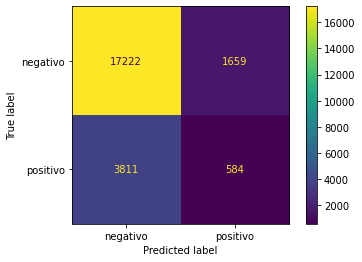

0.7649939852208283
              precision    recall  f1-score   support

           0       0.82      0.91      0.86     18881
           1       0.26      0.13      0.18      4395

    accuracy                           0.76     23276
   macro avg       0.54      0.52      0.52     23276
weighted avg       0.71      0.76      0.73     23276



In [16]:
plt.figure(figsize=(10,6))
metrics.plot_confusion_matrix(modelo, X_test, y_test, display_labels=['negativo', 'positivo'])

plt.show()
accuracy = metrics.accuracy_score(y_test, preds)
print(accuracy) 
print(metrics.classification_report(y_test, preds))

# **Analizo Resultados**
Copié debajo del texto una foto del modelo hecho en las entregas anteriores, donde la base de datos no estaba tan pulida. Interpreto que el modelo empeoró al mejorar la base de datos? o la reducción de pacientes hace que la capacidad de predicción empeore?

Precisión para 0: 0.82: Alta precisión para detectar los negativos, es decir, los que predice como negativos en su gran mayoria son negativos. Si el modelo dice que un paciente no tiene enfermedad cardiovascular, es muy probable que así lo sea. Aunque comparado con el modelo realizado en entregas anteriores, con la base de datos sin limpiar, esta precisión es mejor con la base anterior. 

Precisión para 1: 0.26: baja precisión para detectar los positivos. Es decir, es probable que una persona que tiene enfermedad cardiovascular no lo detecte como tal. Empeoró con la base de datos limpia.

Sensibilidad 0.91: Tiene alta sensibilidad para detectar los negativos, o sea para detectar que un paciente no tiene enfermedad cardiovascular.

Sensibilidad 0.11: Tiene pocas probabilidades de detectar como positivo al paciente que cuenta y cumple con los criterios para enfermedad cardiovascular. Aunque este desempeño mejoró con la base de datos limpia.

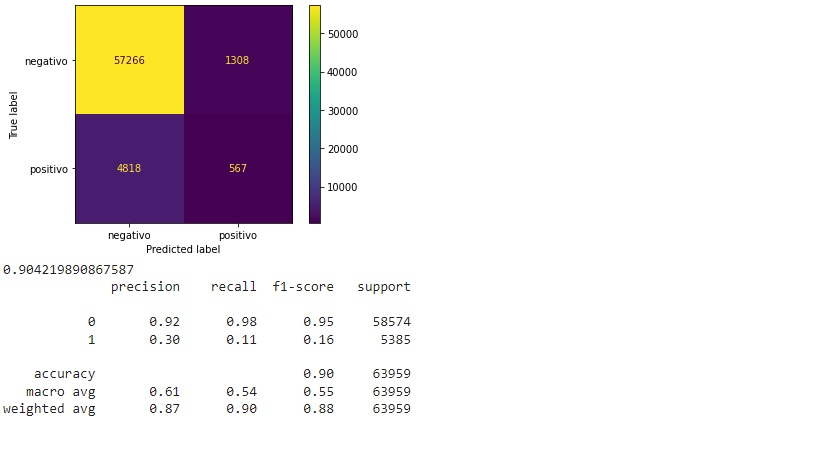

# Probamos la predicción con datos ingresados

In [17]:
al=float(input("Ingrese su altura en metros  "))
pe=int(input("Ingrese su peso  "))
fu=int(input("Usted fuma? 1[si] / 0[no]  "))
st=int(input("Tuvo alguna vez infarto o preinfarto? 1[si] / 0[no]  "))
di=int(input("Se cansa o tiene dolor en las piernas al caminar? 1[si] / 0[no]  "))
se=int(input("Sexo? 1[Hombre] / 0[Mujer]"  ))
di2=int(input("Es diabético? 1[si] / 0[no]"  ))
ph=int(input("Realiza actividad física en la semana 1[si] / 0[no]"  ))

nuevobmi= (pe/(al*al))
nuevopaciente2=pd.DataFrame(np.array([[nuevobmi,fu,st,di,se,di2,ph]]),columns=['BMI','Smoking_Yes', 'Stroke_Yes','DiffWalking_Yes', 'Sex_Male', 'Diabetic_Yes','PhysicalActivity_Yes'])
mm=modelo.predict(nuevopaciente2)

print("--------------------------------")
print("En base a los registros que obtuvimos de 200.000 pacientes durante el año 2020, con los datos ingresados, podemos llegar a concluir que ud.")

if mm == 1 :
  print("tiene alta probabilidad de sufrir algún tipo de enfermedad cardiovascular.")
  print("Es recomendable que haga cambios en su estilo de vida, considere bajar un cambio...para empezar!")
elif mm == 0:
  print("tiene pocas probabilidades de sufrir algún tipo de enfermedad cardiovascular")
  print("Felicitaciones!! Continúe así!!!")


Ingrese su altura en metros  1.80
Ingrese su peso  93
Usted fuma? 1[si] / 0[no]  0
Tuvo alguna vez infarto o preinfarto? 1[si] / 0[no]  0
Se cansa o tiene dolor en las piernas al caminar? 1[si] / 0[no]  0
Sexo? 1[Hombre] / 0[Mujer]1
Es diabético? 1[si] / 0[no]0
Realiza actividad física en la semana 1[si] / 0[no]1
--------------------------------
En base a los registros que obtuvimos de 400.000 pacientes durante el año 2020, con los datos ingresados, podemos llegar a concluir que ud.
tiene pocas probabilidades de sufrir algún tipo de enfermedad cardiovascular
Felicitaciones!! Continúe así!!!


# **Reflexión:**

El modelo trabaja con variables que no son muy específicas, con lo que la precisión del modelo para detectar los positivos puede ser disminuida. Aunque esto puede ser una desventaja, observamos que son variables que pueden ser obtenidas facilmente sin necesidad de invadir al paciente (sacar sangre, hacer pruebas de laboratorio o de imagenes o necesitar registro hospitalario) Hasta mediante una aplicación, web o encuesta pueden obtenerse estos datos. 

Sería interesante comparar este modelo con el gold standard Score de Framingham.

Observo que la métrica de la predicción empeoró despues de realizarse eliminacion de outliers, duplicados y categorias no relacionadas. Aunque mejoró levemente la capacidad de detectar al positivo como positivo.

Vemos altos negativos predecidos que realmente son negativos, podemos concluir que este modelo sirve para descartar enfermedad cardiovascular, de alguna manera. Ya que si con un nuevo paciente, me predice ausencia de enfermedad, es muy probable que así lo sea.

Concluyo que francamente debo agregar variables de mayor correlación. Las categorias de edad creo que seria importantísimo. Leyendo la bibliografía al final del notebook, encuentro la relación entre SleepTime y Obesidad. A menor tiempo de sueño se correlaciona con mayor peso. Otra variable que podria agregar.

Pero teniendo en cuenta que la implementación de este modelo nos permite acercarnos a la predicción y rápidamente hacer un screening de EC con preguntas simples y rápidas, creo que puede cumplir con su cometido.
Aunque creo que debe ser sometido a comparación con el Score de Framingham o probar con otro tipo de población y luego sacar nuevas conclusiones.

Como desafio pendiente, me queda mejorar la métrica de la predicción, para tener en cuenta en los próximos trabajos.




# **Bibliografía para leer**

1- https://www.framinghamheartstudy.org/fhs-risk-functions/cardiovascular-disease-10-year-risk/

2- https://www.mdcalc.com/calc/38/framingham-risk-score-hard-coronary-heart-disease

3- Rodríguez-Artalejo F y Banegas Banegas JR. De la ecuación de Framingham a la prevención cardiovascular. Med Clin (Barc) 2003; 121: 334-6.

4- Ramos R, Marrugat J. Valoración del riesgo cardiovascular en la población. En: Del Río Ligori A, editor. Manual de Cardiología Preventiva. Madrid: SMC; 2005

5-https://my.clevelandclinic.org/health/articles/17308-obesity--heart-disease 